In [127]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

import sys
sys.path.append('../')

from system_functions import *

In [128]:
# Download the dataset
dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = dataframe.values
dataframe.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


In [129]:
# The last element contains the labels
labels = raw_data[:, -1]

# The other data points are the electrocadriogram data
data = raw_data[:, 0:-1]


In [134]:
anom_count = 0
reg_count = 0
for label in labels:
    if label==0:
        anom_count+=1
    elif label==1:
        reg_count+=1
print(len(data),anom_count,reg_count)

4998 2079 2919


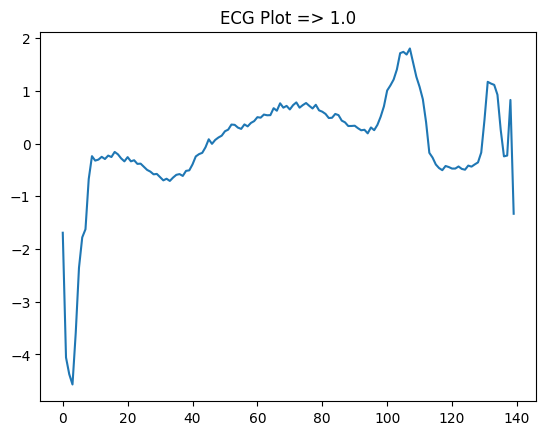

In [31]:
idx  = np.random.randint(5000)
plt.plot(data[idx])
plt.title(f"ECG Plot => {labels[idx]}")
plt.show()

In [32]:
regs = []
anoms = []
for i in range(4900):
    if labels[i] == 0:
        anoms.append(data[i])
    else:
        regs.append(data[i])

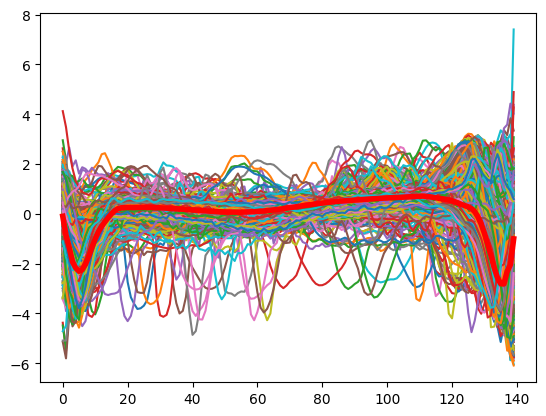

In [33]:
plt.plot(np.transpose(anoms))
plt.plot(np.mean(anoms,axis=0),linewidth=4, color='r')
plt.show()

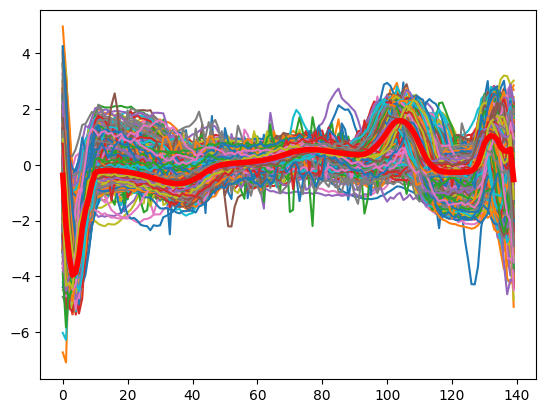

In [34]:
plt.plot(np.transpose(regs))
plt.plot(np.mean(regs,axis=0),linewidth=4, color='r')
plt.show()

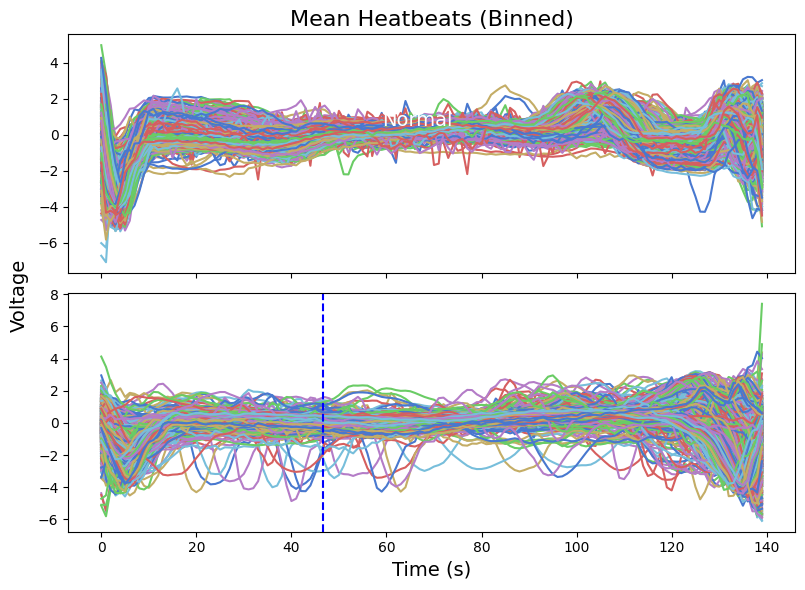

In [241]:
plt_anoms = np.transpose(anoms)
plt_mean_anoms = np.mean(anoms,axis=0)

plt_regs = np.transpose(regs)
plt_mean_regs = np.mean(regs,axis=0)


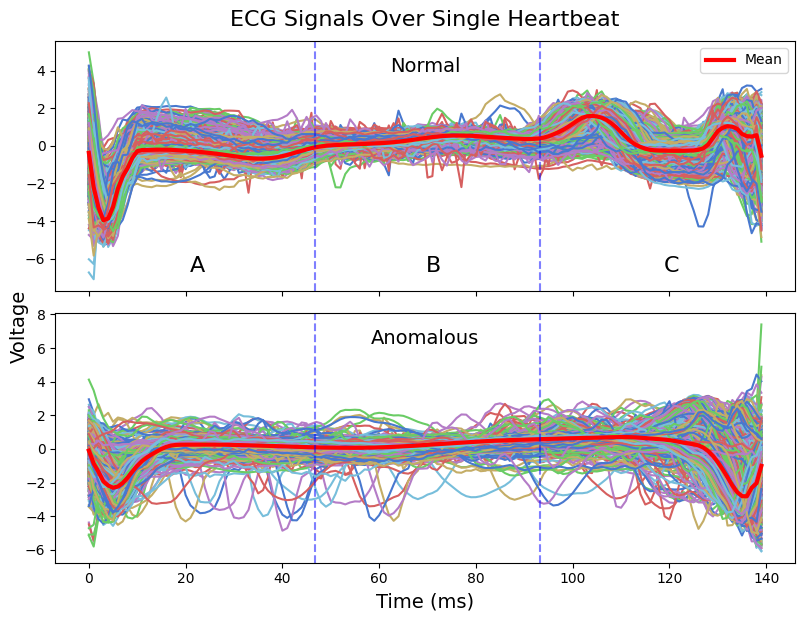

In [309]:


fig,ax = plt.subplots(2,1,figsize=(8,6), sharex=True)
# plt.title("ECG Signals for Single Heartbeats")
ax[0].set_title("Normal",y=1.0, pad=-22,fontsize=14)
ax[0].plot(plt_regs)
ax[0].plot(plt_mean_regs,linewidth=3,color='r',label='Mean')
ax[0].legend()

# ax[1].set_title("Pixelized  Anomalous Heatbeat",fontsize=16)
ax[1].set_title("Anomalous",y=1.0, pad=-22,fontsize=14)
ax[1].plot(plt_anoms)
ax[1].plot(plt_mean_anoms,linewidth=3,color='r')

for i in range(1,3):
    ax[1].axvline(x = i*len(plt_anoms)/3, linestyle='--',color = 'b',alpha=.5)
    ax[0].axvline(x = i*len(plt_anoms)/3, linestyle='--',color = 'b',alpha=.5)

ax[1].set_xlabel("Time (ms)",fontsize=14)
fig.text(.275, 1.01, 'ECG Signals Over Single Heartbeat', va='center', fontsize=16)
fig.text(0, 0.5, 'Voltage', va='center', rotation='vertical', fontsize=14)

fig.text(.2242, .6, 'A', va='center', fontsize=16)
fig.text(.52, .6, 'B', va='center', fontsize=16)
fig.text(.8175, .6, 'C', va='center', fontsize=16)

# fig.text(.45, 0.42, 'Anomalous', va='center', color='white', fontsize=14)
# fig.text(.465, 0.79, 'Normal', va='center', color='white', fontsize=14)
plt.subplots_adjust(top=2.125)
plt.tight_layout()
# plt.savefig("../results/figs/ecg_signals")
plt.show()


In [206]:
mn_reg  = np.mean(regs,axis=0)
mn_anom = np.mean(anoms,axis=0)
mn_rg_dat = mn_reg
mn_rg_dat=np.append(mn_rg_dat,1)
mn_an_dat = mn_anom
mn_an_dat=np.append(mn_an_dat,0)
mean_raw_data = np.array([mn_rg_dat,mn_an_dat])
print(mean_raw_data)

[[-3.74097648e-01 -2.20488285e+00 -3.29159746e+00 -3.95533282e+00
  -3.85827076e+00 -3.24906095e+00 -2.28223458e+00 -1.62627370e+00
  -1.18812660e+00 -6.40333629e-01 -2.85805126e-01 -2.25156607e-01
  -2.17784218e-01 -2.11703126e-01 -2.04745930e-01 -2.03763376e-01
  -2.05630927e-01 -2.12148417e-01 -2.29640417e-01 -2.45187922e-01
  -2.60125268e-01 -2.79873191e-01 -2.99025911e-01 -3.24992577e-01
  -3.51483545e-01 -3.78604552e-01 -4.09182454e-01 -4.43045827e-01
  -4.78774770e-01 -5.13590823e-01 -5.50063714e-01 -5.85596003e-01
  -6.22305446e-01 -6.48460121e-01 -6.67410963e-01 -6.78086384e-01
  -6.74116740e-01 -6.61886077e-01 -6.38575351e-01 -6.02779544e-01
  -5.49809292e-01 -4.87058191e-01 -4.16589269e-01 -3.40652822e-01
  -2.63803015e-01 -1.90600740e-01 -1.23806505e-01 -7.15647920e-02
  -2.93479777e-02  2.29583599e-03  2.27727648e-02  3.84365010e-02
   5.20761178e-02  6.37461004e-02  7.02911403e-02  8.00423532e-02
   8.77811679e-02  9.84314483e-02  1.11751621e-01  1.25407385e-01
   1.36918

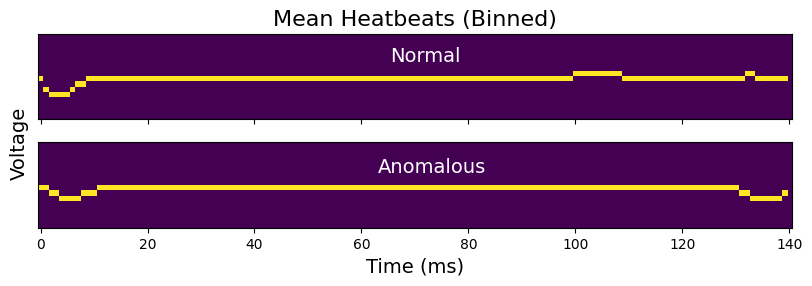

In [308]:
def convert_and_plot_signal(signal):
    input_signals = np.zeros((16,141))
    for t,val in enumerate(signal):
        rnd = 16 - (int(val) + 8)
        # print(rnd)
        rnd_idx = np.clip(rnd,0,16)
        input_signals[rnd_idx][t] = 1

    return input_signals


convert_and_plot_signal(mn_anom)
convert_and_plot_signal(mn_reg)


fig,ax = plt.subplots(2,1,figsize=(8,3), sharex=True)
# plt.title("ECG Signals for Single Heartbeats")
ax[0].set_title("Mean Heatbeats (Binned)",fontsize=16)
ax[0].imshow(convert_and_plot_signal(mn_reg))
# ax[0].legend()
ax[0].set_yticks([])
# ax[1].set_title("Pixelized  Anomalous Heatbeat",fontsize=16)
ax[1].imshow(convert_and_plot_signal(mn_anom))

ax[1].set_yticks([])
ax[1].set_xlabel("Time (ms)",fontsize=14)
fig.text(-0.01, 0.5, 'Voltage', va='center', rotation='vertical', fontsize=14)

fig.text(.45, 0.42, 'Anomalous', va='center', color='white', fontsize=14)
fig.text(.465, 0.79, 'Normal', va='center', color='white', fontsize=14)
# plt.subplots_adjust(left=.5)
plt.tight_layout()
# plt.savefig("../results/figs/ecg_binned")
plt.show()


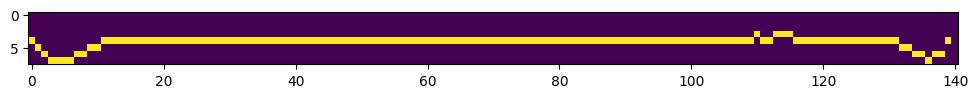

In [114]:
idx  = np.random.randint(5000)
convert_and_plot_signal(data[idx])

In [296]:
def make_ecg_dataset(raw_data,bins,rng):

    labels = raw_data[:, -1]
    data = raw_data[:, 0:-1]
    print(len(labels),len(data))
    regs = []
    anoms = []
    anom_spikes = []
    reg_spikes = []

    reg_spikes  = []

    span = rng[1]-rng[0]

    for i in range(len(labels)):

        signal = data[i]

        # input_spike_rows = np.zeros((8,141))
        input_spike_rows = [[] for _ in range(bins)]
        for t,val in enumerate(signal):
            rnd = bins - (int(val) + int(bins/2))
            binned = (val-rng[0])

            rnd = int(binned)
            # print(val,binned,rnd)

            rnd_idx = np.clip(rnd,0,bins-1)
            # input_spike_rows[rnd_idx][t] = 1
            if len(input_spike_rows[rnd_idx]) > 0:
                if t - input_spike_rows[rnd_idx][-1] > 35:
                    input_spike_rows[rnd_idx].append(t)
            else:
                input_spike_rows[rnd_idx].append(t)

        if labels[i] == 0:
            anoms.append(signal)
            anom_spikes.append(input_spike_rows)
        elif labels[i] == 1:
            regs.append(signal)
            reg_spikes.append(input_spike_rows)

    print(f"Dataset with {len(reg_spikes)} regular ECG inputs and {len(anom_spikes)} anomalies generated.")
    return (reg_spikes, anom_spikes)

    
all_spikes = (reg_spikes, anom_spikes) = make_ecg_dataset(raw_data,16,[-6,6])
# picklit(all_spikes,".","ecg_spikes")

# all_spikes = (reg_spikes, anom_spikes) = make_ecg_dataset(mean_raw_data,16,[-6,6])


4998 4998
Dataset with 2919 regular ECG inputs and 2079 anomalies generated.


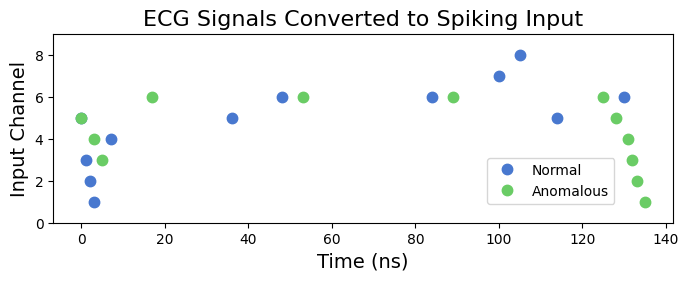

In [298]:


def raster_plot_rows(rows):
    times = []
    indices = []
    for i,row in enumerate(rows):
        if len(row)>0:
            for t in row:
                times.append(t)
            indices+=list(np.ones(len(row))*i)
    return times,indices

plt.style.use('seaborn-v0_8-muted')
sig_names = ['Normal','Anomalous']
colors = ['r','b']
plt.figure(figsize=(8,3))
plt.title("ECG Signals Converted to Spiking Input",fontsize=16)
plt.xlabel("Time (ns)",fontsize=14)
plt.ylabel("Input Channel",fontsize=14)
for i in range(2):
    times,indices = raster_plot_rows(all_spikes[i][0])
    plt.plot(times,indices,'.',label=sig_names[i],ms=15)
plt.ylim(0,9)
plt.legend(loc=(.7,.1))
plt.subplots_adjust(bottom=.25)
# plt.savefig("../results/figs/ecg_raster")
plt.show()

# raster_plot_rows(all_spikes[0][0])

In [123]:
reg_spikes[2]
        

[[],
 [3],
 [2],
 [1],
 [6],
 [0, 36, 112],
 [47, 83, 129],
 [98],
 [102],
 [],
 [],
 [],
 [],
 [],
 [],
 []]

In [86]:
for row in reg_spikes[0]:
    print(row)

[]
[]
[]
[]
[]
[]
[]
[]
[0, 36, 72, 108]
[3, 131]
[5, 132]
[133]
[135]
[]
[]
[]


In [77]:
import numpy as np
import matplotlib.pyplot as plt
import time
import sys
sys.path.append('../')

from neuron import Neuron
from network import Network
import components

from weight_structures import *
from learning_rules import *
from plotting import *
from system_functions import *
from argparser import setup_argument_parser

[2, 2, 4, 8, 16]


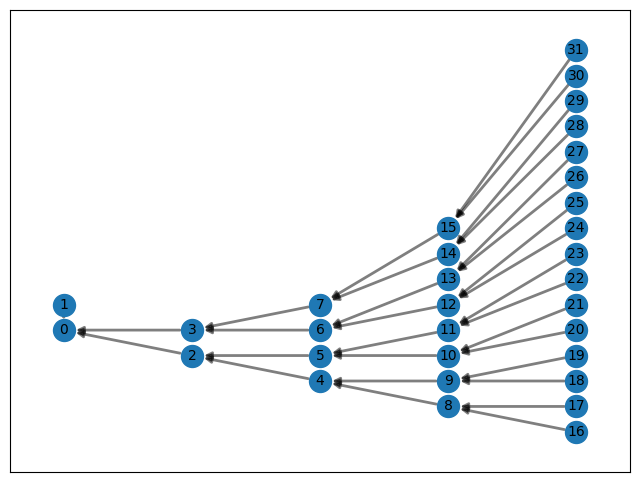

In [126]:
W = [
[np.ones((2,))],
np.ones((2,2)),
np.ones((4,2)),
np.ones((8,2)),
]
neurons = []
for i in range(2):
    neuron = Neuron(
        name=f'node_{i}',
        threshold = 0.25,
        weights=W,
        )
    neuron.normalize_fanin_symmetric(fanin_factor=2)
    neurons.append(neuron)
    if i == 0:
        graph_adjacency(neuron.adjacency,neuron.get_dimensions())

In [79]:
def plot_trajectories(nodes,double_dends=False):
    colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    fig,ax = plt.subplots(len(nodes),1,figsize=(8,2.25*len(nodes)), sharex=True)
    for n,node in enumerate(nodes):

        ax[n].set_title(f"Update Trajectory of {node.name} Arbor",fontsize=12)
        for dend in node.dendrite_list:
            if hasattr(dend,'update_traj') and 'ref' not in dend.name:
                if isinstance(dend,components.Soma): 
                    lw = 4
                    c = colors[2]
                    line='solid'

                elif dend.loc[0]==1:
                    c = colors[3] 
                    lw = 2 
                    line = 'dashed'
                elif dend.loc[0]==3:
                    # print(dend.name, dend.outgoing[0][1])
                    if dend.outgoing[0][1] < 0:
                        c = 'r' 
                    else:
                        c = 'g'
                    lw = 2   
                    line = 'dotted'
                else:
                    c = colors[4]
                    lw = 1
                    line = 'dotted'

                ax[n].plot(np.array(dend.update_traj),linewidth=lw,linestyle=line,color=c,label=dend.name)

        # plt.legend(bbox_to_anchor=(1.01,1))
        # ax[n].set_x_label("Updates",fontsize=14)
        # ax[n].set_y_label("Flux Offset",fontsize=14)
    fig.tight_layout()
    plt.show()

In [80]:
def run_net(neurons,inpt,targets,duration=150,learn=True,plotting=False):
    for i,neu  in enumerate(neurons):
        neu.add_spike_rows(inpt)
    net = Network(
        run_simulation = True,
        nodes          = neurons,
        duration       = duration,
    )
    if plotting == True:
        plot_nodes(neurons)
        for n,neuron in enumerate(neurons):
            plot_by_layer(neuron,3,flux=False)
            # for d in neuron.dendrite_list:
            #     if d.loc[0]==3:
            #         plt.plot(d.flux)
            # plt.show()
    outputs = []
    for n,neuron in enumerate(neurons):
        output = len(neurons[n].dend_soma.spikes)
        outputs.append(output)
        error = targets[n] - outputs[n]
        if learn==True:
            make_update(neuron,error,eta,max_offset,updater)

    clear_net(net)
    return outputs

In [81]:
W = [
[np.ones((2,))],
np.ones((2,2)),
np.ones((4,2)),
]
neurons = []
for i in range(2):
    neuron = Neuron(
        name=f'node_{i}',
        threshold = 0.25,
        weights=W,
        )
    neuron.normalize_fanin_symmetric(fanin_factor=2)
    neurons.append(neuron)

train = 10
test  = 2
eta = 0.005
max_offset = 0.8
updater = 'classic'
runs = 1



for run in range(runs):   
    success = 0 
    for trn in range(train):
        targets = [1,0]
        outputs = run_net(neurons,reg_spikes[trn],targets,plotting=False)
        if np.argmax(outputs)==np.argmax(targets): success+=1
        print(f"Run {run}  ::  {targets} -> {outputs}  :: {success}/{trn*2+1}",end="\r")


        targets = [0,1]
        outputs = run_net(neurons,anom_spikes[trn],targets,plotting=False)
        if np.argmax(outputs)==np.argmax(targets): success+=1
        print(f"Run {run}  ::  {targets} -> {outputs}  ::  {success}/{trn*2+2}",end="\r")


plot_trajectories(neurons)


IndexError: list index out of range

In [17]:
success=0
seen = 0
test= 100
for tst in range(train,train+test):
    seen+=1
    targets = [1,0]
    outputs = run_net(neurons,reg_spikes[tst],targets,learn=False,plotting=False)
    if np.argmax(outputs)==np.argmax(targets): success+=1
    print(f"{targets} -> {outputs}  :: {success}/{seen}",end="\r")

    # plt.figure(figsize=(12,12))
    # plt.imshow(reg_spikes[tst])
    # plt.show()

    seen+=1
    targets = [0,1]
    outputs = run_net(neurons,anom_spikes[tst],targets,learn=False,plotting=False)
    if np.argmax(outputs)==np.argmax(targets): success+=1
    print(f"{targets} -> {outputs}  :: {success}/{seen}",end="\r")

    # plt.figure(figsize=(12,12))
    # plt.imshow(anom_spikes[tst])
    # plt.show()


In [14]:
W = [
[np.ones((2,))],
np.ones((2,2)),
np.ones((4,2)),
]

chunks = ['A','B','C','D']
labels = [0,1]

nodes = []
for chunk in chunks:
    for label in labels:
        
        neurons = []
        neuron = Neuron(
            name=f'node_{chunk}{label}',
            threshold = 0.25,
            weights=W,
            )
        neuron.normalize_fanin_symmetric(fanin_factor=2)
        nodes.append(neuron)
print(len(nodes))
print_attrs(nodes,['name'])

8


  node_A0  
  node_A1  
  node_B0  
  node_B1  
  node_C0  
  node_C1  
  node_D0  
  node_D1  




['node_A0',
 'node_A1',
 'node_B0',
 'node_B1',
 'node_C0',
 'node_C1',
 'node_D0',
 'node_D1']

In [15]:
def spikes_to_chunks(in_spikes,start,stop):
    chunk_spikes = [[] for _ in range(8)]
    for c,channel in enumerate(in_spikes):
        for spk in channel:
            if spk >= start and spk < stop:
                chunk_spikes[c].append(spk-start)
    return chunk_spikes

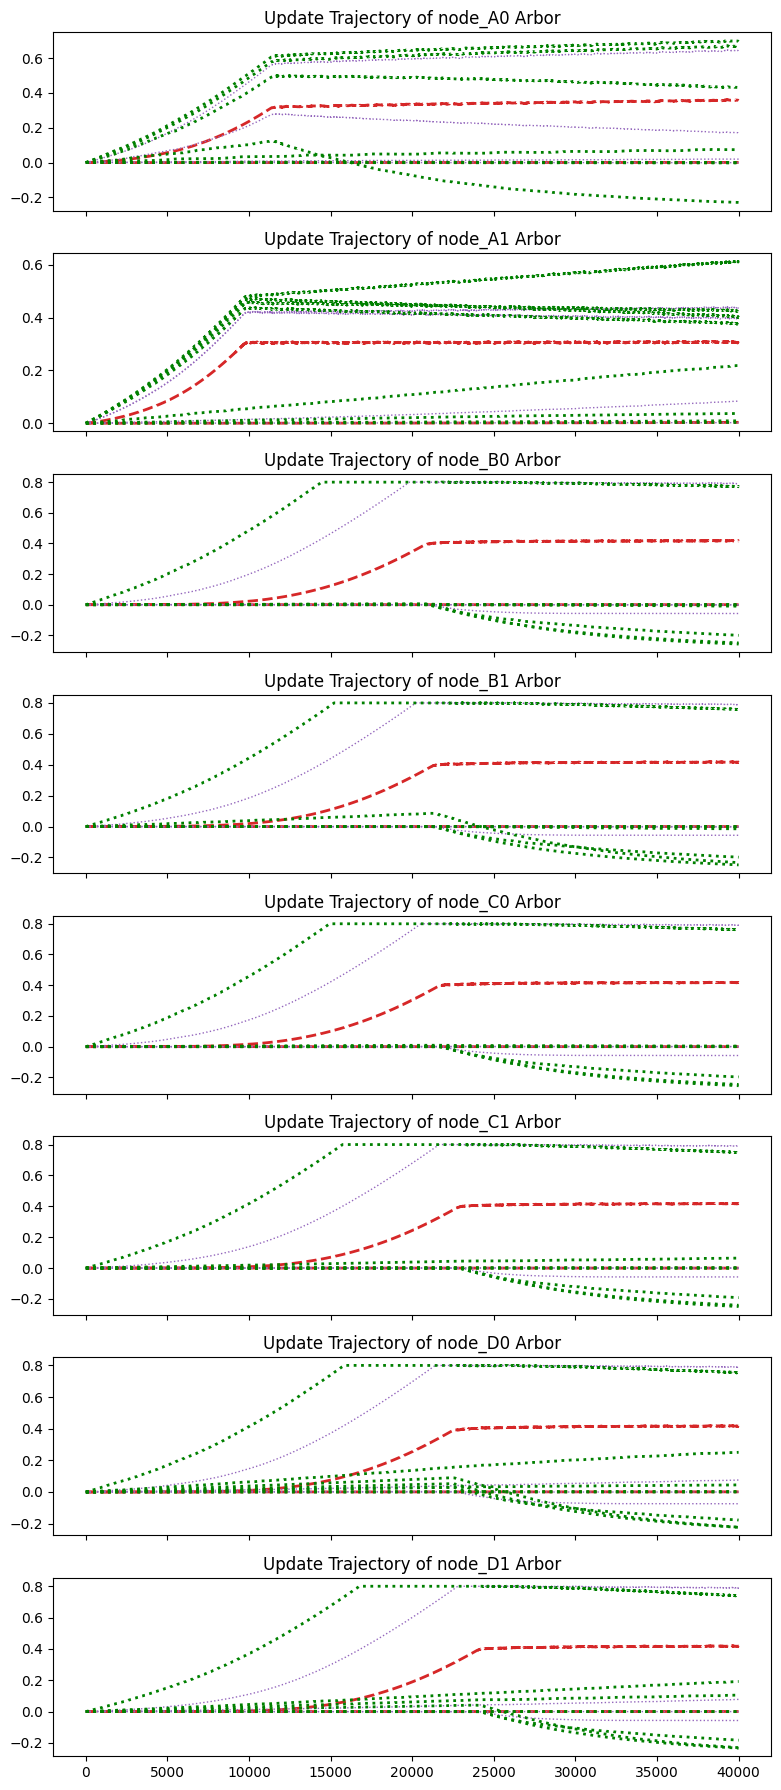

In [18]:
train = 500
test  = 1
eta = 0.001
max_offset = 0.8
updater = 'classic'
duration = 140
runs = 3
window = int(duration/len(chunks))

for run in range(runs):   
    success = 0 
    for trn in range(train):


        for i, chunk in enumerate(chunks):

            start = i*window
            stop = i*window+window
        

            ### Regular ECG Signals ###
            in_spikes = reg_spikes[trn]
            chunk_spikes = spikes_to_chunks(in_spikes,start,stop)

            targets = np.zeros((8,))
            targets[i*2] = 1

            

            outputs = run_net(nodes,chunk_spikes,targets,duration=window,plotting=False)


            ### Anomolous ECG Signals ###
            in_spikes = anom_spikes[trn]
            chunk_spikes = spikes_to_chunks(in_spikes,start,stop)

            targets = np.zeros((8,))
            targets[i*2+1] = 1

            outputs = run_net(nodes,chunk_spikes,targets,duration=window,plotting=False)

            print(f"Run {run}  --  sample {trn}",end="\r")

plot_trajectories(nodes)



In [21]:
def run_timing_test(nodes,inpt,duration,plotting=False):
    for i,neu  in enumerate(neurons):
        neu.add_spike_rows(inpt)
    net = Network(
        run_simulation = True,
        nodes          = nodes,
        duration       = duration,
    )
    if plotting == True:
        plot_nodes(neurons)
        for n,neuron in enumerate(neurons):
            plot_by_layer(neuron,3,flux=False)

    outputs = []
    for n,neuron in enumerate(neurons):
        output = len(neurons[n].dend_soma.spikes)
        outputs.append(output)

    clear_net(net)
    return outputs
    



  timing_node    150  
  timing_node_dend_ref    150  
  timing_node_dend_1_0_0    140  
  timing_node_dend_1_0_1    105  
  timing_node_dend_1_0_2    70  
  timing_node_dend_1_0_3    35  




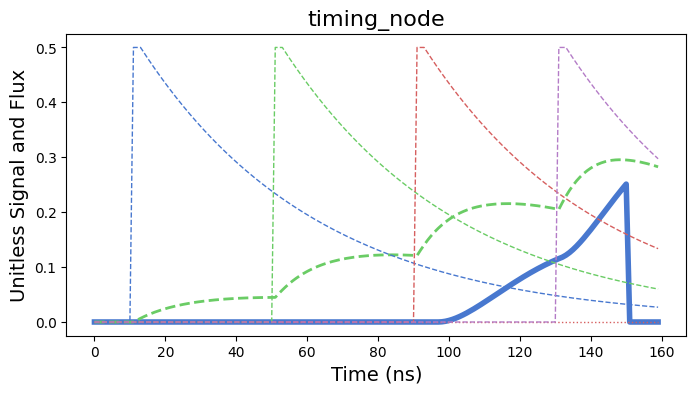

In [295]:
W_timing = [
    [[.1,.2,.3,.4]]
]

arbor_params = [
    [[{'tau':(4*35)},{'tau':(3*35)},{'tau':(2*35)},{'tau':(1*35)}]]
    ]

timing_neuron = Neuron(
    name=f'timing_node',
    threshold = 0.25,
    weights=W_timing,
    arbor_params=arbor_params
    )
neuron.normalize_fanin_symmetric(fanin_factor=2)

print_attrs(timing_neuron.dendrite_list,['name','tau'])

inpt = [
    [10],
    [50],
    [90],
    [130]
]
timing_neuron.add_spike_rows(inpt)
net = Network(
    run_simulation = True,
    nodes          = [timing_neuron],
    duration       = 160,
)
plot_nodes([timing_neuron],dendrites=True)

In [20]:
nodes[1].dend_soma.outgoing.append([timing_neuron.dendrite_list[0],1])
nodes[3].dend_soma.outgoing.append([timing_neuron.dendrite_list[1],1])
nodes[5].dend_soma.outgoing.append([timing_neuron.dendrite_list[2],1])
nodes[7].dend_soma.outgoing.append([timing_neuron.dendrite_list[3],1])

timing_neuron.dendrite_list[0].dend_soma.incoming.append([nodes[1],1])
timing_neuron.dendrite_list[1].dend_soma.incoming.append([nodes[3],1])
timing_neuron.dendrite_list[2].dend_soma.incoming.append([nodes[5],1])
timing_neuron.dendrite_list[3].dend_soma.incoming.append([nodes[7],1])

AttributeError: 'Soma' object has no attribute 'dend_soma'

In [21]:
tst  = 1
for i,neu  in enumerate(neurons):
    neu.add_spike_rows(reg_spikes[tst])
nodes.append(timing_neuron)
net = Network(
    run_simulation = True,
    nodes          = nodes,
    duration       = duration,
)
plot_nodes(nodes)
# if plotting == True:
#     plot_nodes(neurons)
#     for n,neuron in enumerate(neurons):
#         plot_by_layer(neuron,3,flux=False)

AttributeError: 'list' object has no attribute 'flux'

In [23]:

test  = 1
for tst in range(train,train+test):
    

    outputs = run_net(nodes,reg_spikes[tst],targets,learn=False,plotting=False)
    print(outputs)
    outputs = run_net(nodes,anom_spikes[tst],targets,learn=False,plotting=False)
    print(outputs)    

[4, 5, 2, 2, 2, 2, 5, 6]
[4, 5, 2, 2, 2, 2, 5, 6]
[4, 5, 2, 2, 2, 2, 5, 6]
[4, 5, 2, 2, 2, 2, 5, 6]
[4, 5, 2, 2, 2, 2, 5, 6]
[4, 5, 2, 2, 2, 2, 5, 6]
[4, 5, 2, 2, 2, 2, 5, 6]
[4, 5, 2, 2, 2, 2, 5, 6]
[4, 5, 2, 2, 2, 2, 5, 6]
[4, 5, 2, 2, 2, 2, 5, 6]
[4, 5, 2, 2, 2, 2, 5, 6]
[4, 5, 2, 2, 2, 2, 5, 6]
[4, 5, 2, 2, 2, 2, 5, 6]
[4, 5, 2, 2, 2, 2, 5, 6]
[4, 5, 2, 2, 2, 2, 5, 6]
[4, 5, 2, 2, 2, 2, 5, 6]
[4, 5, 2, 2, 2, 2, 5, 6]
[4, 5, 2, 2, 2, 2, 5, 6]
[4, 5, 2, 2, 2, 2, 5, 6]
[4, 5, 2, 2, 2, 2, 5, 6]
